# CONFIG

In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import os
import sys
sys.path.append('../src')  # Adjust based on your actual structure
from config import DATA_DIR
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

import dataframe_report as dr
import performance_plot as pp

# Evaluation

In [3]:
df_claim_uw = pd.read_parquet('../data/datasets/output/all_data_UWQ4_claim2023_data_allstate_superset.parquet',
                    engine='pyarrow')
df_claim_uw.shape

(14415, 60)

In [4]:
df_claim_uw = df_claim_uw.drop_duplicates(subset='address')

In [5]:
df_claim_uw.address.nunique()

14414

In [6]:
df_claim_uw.claim_exists.value_counts(normalize=True)

claim_exists
0    0.837797
1    0.162203
Name: proportion, dtype: float64

In [7]:
def balance_data(merged_df, method='zip'):
    balanced_dfs = []

    # Ensure DataFrame columns for comparison are in the correct type
    merged_df['claim_exists'] = merged_df['claim_exists'].astype(bool)

    if method == 'zip':
        for zip_code in merged_df['UW_ZIP'].unique():
            df_zip = merged_df[merged_df['UW_ZIP'] == zip_code]
            corresponding_state = df_zip['UW_STATE'].iloc[0]  # Assuming all rows in a ZIP code share the same state

            true_count = (df_zip['claim_exists'] == True).sum()
            false_count = (df_zip['claim_exists'] == False).sum()

            # If there are more false claims than true claims, downsample false claims
            if false_count > true_count:
                df_zip_false = df_zip[df_zip['claim_exists'] == False].sample(n=true_count, replace=False)
                df_zip_true = df_zip[df_zip['claim_exists'] == True]
                df_zip = pd.concat([df_zip_true, df_zip_false])

            # Calculate the shortfall of false claims if there are more true claims than false claims
            elif true_count > false_count:
                shortfall = true_count - false_count
                additional_false = merged_df[(merged_df['UW_STATE'] == corresponding_state) &
                                             (merged_df['claim_exists'] == False) &
                                             (~merged_df['full_address'].isin(df_zip['full_address']))]

                if len(additional_false) >= shortfall:
                    additional_false = additional_false.sample(n=shortfall, replace=False)
                df_zip = pd.concat([df_zip, additional_false])

            balanced_dfs.append(df_zip)

    elif method == 'state':
        for state in merged_df['UW_STATE'].unique():
            df_state = merged_df[merged_df['UW_STATE'] == state]

            true_count = (df_state['claim_exists'] == True).sum()
            false_count = (df_state['claim_exists'] == False).sum()

            # If there are more false claims than true claims, downsample false claims
            if false_count > true_count:
                df_state_false = df_state[df_state['claim_exists'] == False].sample(n=true_count, replace=False)
                df_state_true = df_state[df_state['claim_exists'] == True]
                df_state = pd.concat([df_state_true, df_state_false])

            # Calculate the shortfall of false claims if there are more true claims than false claims
            elif true_count > false_count:
                shortfall = true_count - false_count
                additional_false = merged_df[(merged_df['UW_STATE'] == state) &
                                             (merged_df['claim_exists'] == False) &
                                             (~merged_df['full_address'].isin(df_state['full_address']))]

                if len(additional_false) >= shortfall:
                    additional_false = additional_false.sample(n=shortfall, replace=False)
                df_state = pd.concat([df_state, additional_false])

            balanced_dfs.append(df_state)

    elif method == 'national':
        true_count = (merged_df['claim_exists'] == True).sum()
        false_count = (merged_df['claim_exists'] == False).sum()

        # If there are more false claims than true claims, downsample false claims
        if false_count > true_count:
            df_false = merged_df[merged_df['claim_exists'] == False].sample(n=true_count, replace=False)
            df_true = merged_df[merged_df['claim_exists'] == True]
            merged_df = pd.concat([df_true, df_false])

        # Calculate the shortfall of false claims if there are more true claims than false claims
        elif true_count > false_count:
            shortfall = true_count - false_count
            additional_false = merged_df[merged_df['claim_exists'] == False].sample(n=shortfall, replace=False)
            merged_df = pd.concat([merged_df, additional_false])

        balanced_dfs.append(merged_df)

    else:
        raise ValueError("Invalid balancing method. Choose from 'zip', 'state', or 'national'.")

    balanced_merged_df = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_merged_df



In [8]:
# Usage example:
# method: 'zip', 'state', or 'national'
balanced_df_national = balance_data(df_claim_uw, method='national')
# output_filepath_national = os.path.join(DATA_DIR, 'datasets/output/all_data_UWQ4_claim2023_data_allstate_sampled_national.csv')
# balanced_df_national.to_parquet(output_filepath_national, engine='pyarrow')

balanced_df_zip = balance_data(df_claim_uw, method='zip')
# output_filepath_zip = os.path.join(DATA_DIR, 'datasets/output/all_data_UWQ4_claim2023_data_allstate_sampled_zip.csv')
# balanced_df_zip.to_parquet(output_filepath_zip, engine='pyarrow')

balanced_df_state = balance_data(df_claim_uw, method='state')
# output_filepath_state = os.path.join(DATA_DIR, 'datasets/output/all_data_UWQ4_claim2023_data_allstate_sampled_zip.csv')
# balanced_df_state.to_parquet(output_filepath_state, engine='pyarrow')

In [46]:
import os
import pandas as pd

def calculate_and_save_population_distribution(df, file_path, sheet_name='Population Distribution'):
    """
    Calculate the population distribution based on US states and claim existence, 
    and save the results as a new tab in an Excel file.

    Parameters:
    - df (DataFrame): Input DataFrame containing the data.
    - file_path (str): Path to the Excel file to save the results.
    - sheet_name (str): Name of the tab to save the results in the Excel file.

    Returns:
    None
    """
    df_copy = df.copy()
    if not os.path.exists(file_path):
        with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
            pd.DataFrame(columns=['State', 'Population Count', 'Population Percentage', 'Claim Count', 'Claim Percentage', 'Non-Claim Count', 'Non-Claim Percentage']).to_excel(writer, sheet_name=sheet_name, index=False)
            writer.save()

    # Convert claim_exists to 'Y' for True and 'N' for False
    df_copy['claim_exists'] = df_copy['claim_exists'].astype(str).replace({"True": 'Y', "False": 'N'})

    grouped = df_copy.groupby(['UW_STATE', 'claim_exists']).size().unstack(fill_value=0)
    total_records = grouped.sum(axis=1)

    # Calculate total claims correctly
    total_claims = grouped['Y']
    total_non_claims = grouped['N']

    population_percentage = total_records / total_records.sum() * 100
    claim_percentage = total_claims / total_claims.sum() * 100
    non_claim_percentage = total_non_claims / total_non_claims.sum() * 100
    
    # Round the percentage values to two decimal points
    population_percentage = population_percentage.round(2)
    claim_percentage = claim_percentage.round(2)
    non_claim_percentage = non_claim_percentage.round(2)

    result_df = pd.DataFrame({
        'State': total_records.index,
        'Population Count': total_records.values,
        'Population Percentage': population_percentage.values,
        'Claim Count': total_claims.values,
        'Claim Percentage': claim_percentage.values,
        'Non-Claim Count': total_non_claims.values,
        'Non-Claim Percentage': non_claim_percentage.values
    })

    result_df = result_df[['State', 'Population Count', 'Population Percentage', 'Claim Count', 'Claim Percentage', 'Non-Claim Count', 'Non-Claim Percentage']]

    total_row = pd.DataFrame({
        'State': ['Total'],
        'Population Count': [total_records.sum()],
        'Population Percentage': [100],
        'Claim Count': [total_claims.sum()],
        'Claim Percentage': [100],
        'Non-Claim Count': [total_non_claims.sum()],
        'Non-Claim Percentage': [100]
    })

    result_df = pd.concat([result_df, total_row], axis=0)

    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
        if sheet_name in writer.book.sheetnames:
            idx = writer.book.sheetnames.index(sheet_name)
            writer.book.remove(writer.book.worksheets[idx])
            # writer.book.create_sheet(sheet_name, idx)
        result_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    return result_df


In [47]:
summary_national = calculate_and_save_population_distribution(balanced_df_national, 'rci_score_evaluation.xlsx', sheet_name='National-PD')
summary_zip = calculate_and_save_population_distribution(balanced_df_zip, 'rci_score_evaluation.xlsx', sheet_name='zip-PD')
summary_state = calculate_and_save_population_distribution(balanced_df_state, 'rci_score_evaluation.xlsx', sheet_name='state-PD')
summary_sampled_data = calculate_and_save_population_distribution(df_claim_uw, 'rci_score_evaluation.xlsx', sheet_name='1-to-5-sample-PD')

# Evaluate all models

In [66]:
# Define evaluation function
def evaluate_model(y_true, scores, threshold=0.5):
    y_pred = (scores >= threshold).astype(int)
    accuracy = round(accuracy_score(y_true, y_pred), 2)
    precision = round(precision_score(y_true, y_pred), 2)
    recall = round(recall_score(y_true, y_pred), 2)
    f1 = round(f1_score(y_true, y_pred), 2)
    roc_auc = round(roc_auc_score(y_true, scores), 2)
    return accuracy, precision, recall, f1, roc_auc

# Load and preprocess datasets
sampled_dfs = [balanced_df_national, 
               balanced_df_zip, 
               balanced_df_state, 
               df_claim_uw]
indeces = ['National Sampled (1:1)', 
           'Zip Sampled (1:1)', 
           'State Sampled (1:1)', 
           'National Sampled (1:5)']
threshold = 0.5
results = []

for df in sampled_dfs:
    y_true = df['claim_exists']
    scores = df['rci_score_v1.0'] / 10 # Assuming the model's prediction scores are in 'model_column'
    evaluation_results = evaluate_model(y_true, scores, threshold=threshold)
    results.append(evaluation_results)

# Create DataFrame to display results
metrics = [f'Accuracy ({threshold})', 
           f'Precision ({threshold})', 
           f'Recall ({threshold})', 
           f'F1-score ({threshold})', 'ROC AUC']
results_df = pd.DataFrame(results, columns=metrics)
results_df.index = indeces#[f'Dataset {i+1}' for i in range(len(sampled_dfs))]
print(results_df)

file_path = 'rci_score_evaluation.xlsx'
sheet_name='Evaluation Results v1.0'
with pd.ExcelWriter(path=file_path, engine='openpyxl', mode='a') as writer:
    if sheet_name in writer.book.sheetnames:
        idx = writer.book.sheetnames.index(sheet_name)
        writer.book.remove(writer.book.worksheets[idx])
    results_df.to_excel(writer, sheet_name=sheet_name, index=True)

                        Accuracy (0.5)  Precision (0.5)  Recall (0.5)  \
National Sampled (1:1)            0.50             0.62          0.01   
Zip Sampled (1:1)                 0.50             0.86          0.01   
State Sampled (1:1)               0.50             0.74          0.01   
National Sampled (1:5)            0.84             0.34          0.01   

                        F1-score (0.5)  ROC AUC  
National Sampled (1:1)            0.02     0.47  
Zip Sampled (1:1)                 0.02     0.51  
State Sampled (1:1)               0.02     0.51  
National Sampled (1:5)            0.02     0.47  


In [67]:
threshold = 0.5
results = []
for df in sampled_dfs:
    y_true = df['claim_exists']
    scores = df['rci_score_v1.1'] / 10 # Assuming the model's prediction scores are in 'model_column'
    evaluation_results = evaluate_model(y_true, scores, threshold=threshold)
    results.append(evaluation_results)

# Create DataFrame to display results
metrics = [f'Accuracy ({threshold})', 
           f'Precision ({threshold})', 
           f'Recall ({threshold})', 
           f'F1-score ({threshold})', 'ROC AUC']
results_df = pd.DataFrame(results, columns=metrics)
results_df.index = indeces#[f'Dataset {i+1}' for i in range(len(sampled_dfs))]
print(results_df)

file_path = 'rci_score_evaluation.xlsx'
sheet_name='Evaluation Results v1.1'
with pd.ExcelWriter(path=file_path, engine='openpyxl', mode='a') as writer:
    if sheet_name in writer.book.sheetnames:
        idx = writer.book.sheetnames.index(sheet_name)
        writer.book.remove(writer.book.worksheets[idx])
    results_df.to_excel(writer, sheet_name=sheet_name, index=True)

                        Accuracy (0.5)  Precision (0.5)  Recall (0.5)  \
National Sampled (1:1)            0.50             0.50          0.53   
Zip Sampled (1:1)                 0.52             0.52          0.53   
State Sampled (1:1)               0.52             0.52          0.53   
National Sampled (1:5)            0.49             0.16          0.53   

                        F1-score (0.5)  ROC AUC  
National Sampled (1:1)            0.51     0.52  
Zip Sampled (1:1)                 0.52     0.52  
State Sampled (1:1)               0.52     0.53  
National Sampled (1:5)            0.25     0.52  


In [59]:
[col for col in balanced_df_national.columns if 'score' in col.lower()]

['weatherVerification_hailRiskScore',
 'roofConditionInsightsScore_riskScore',
 'roofConditionInsightsScore_riskDescription',
 'rci_score_v1.0',
 'rci_score_v1.1',
 'rci_raw_score_v1.0',
 'rci_raw_score_v1.1']

## Claim vs No Claim - Zip Code Stratified

# Evaluation


---
National Sampled (1:1) Processing ...
Column 'run_completed' converted from bool to int.
Column 'claim_exists' converted from bool to int.


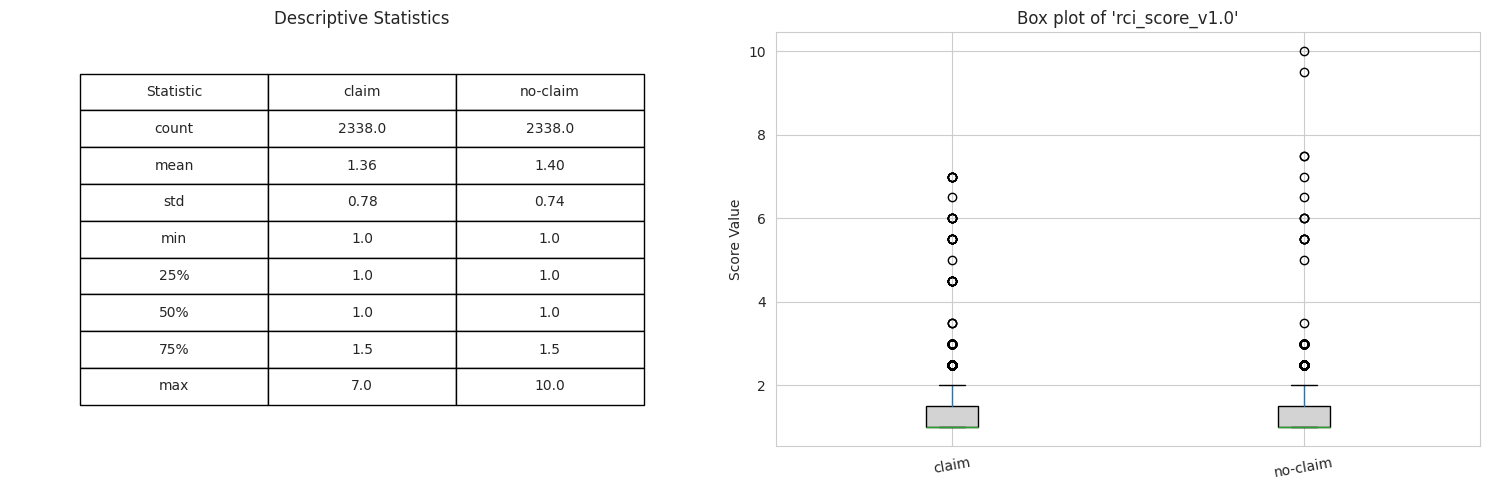

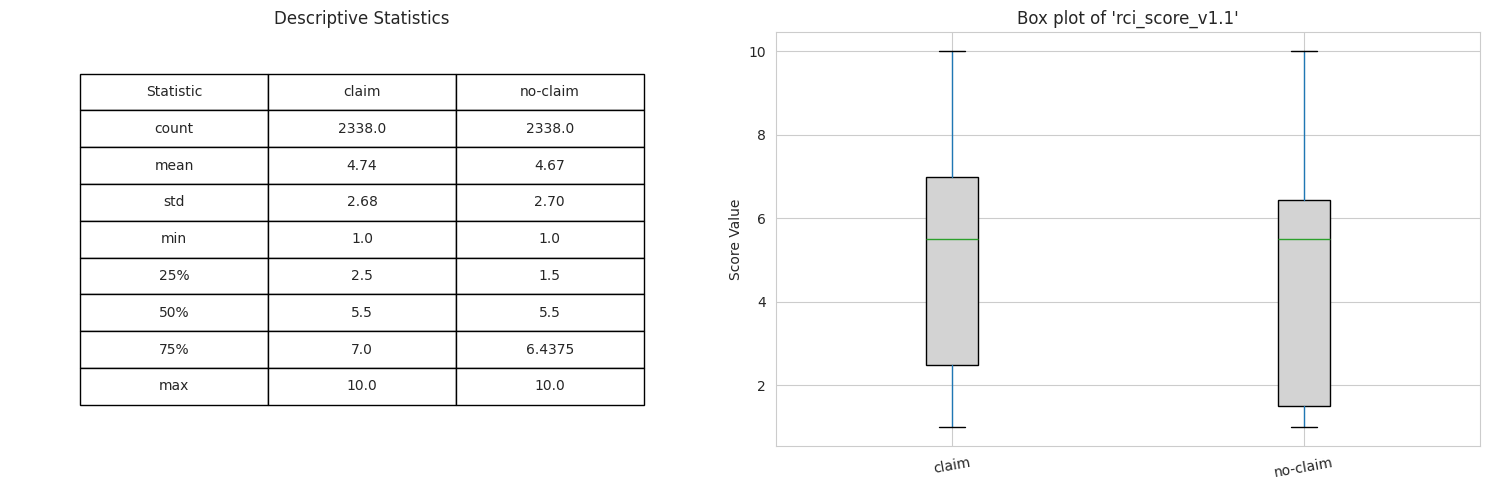

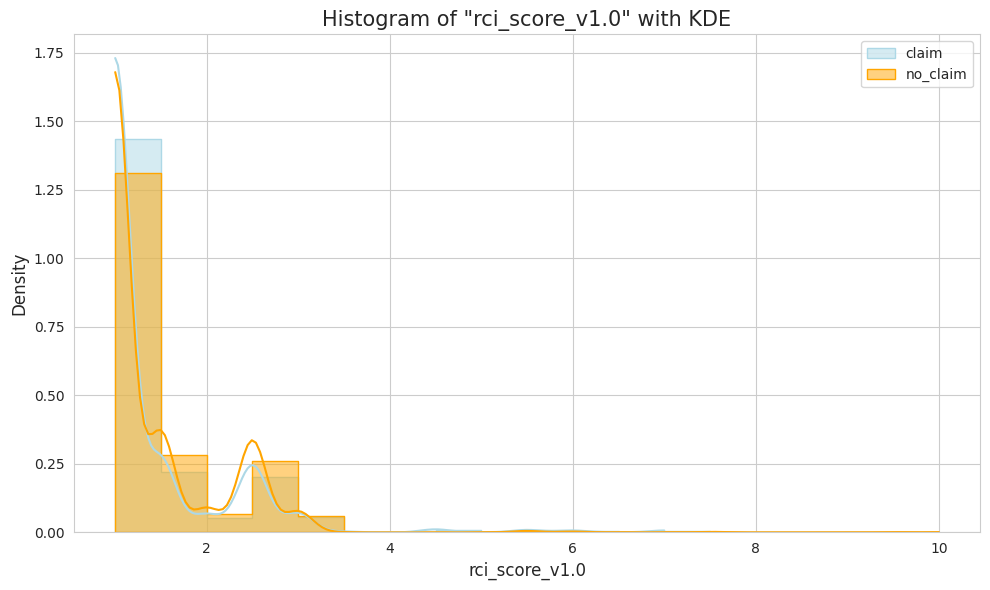

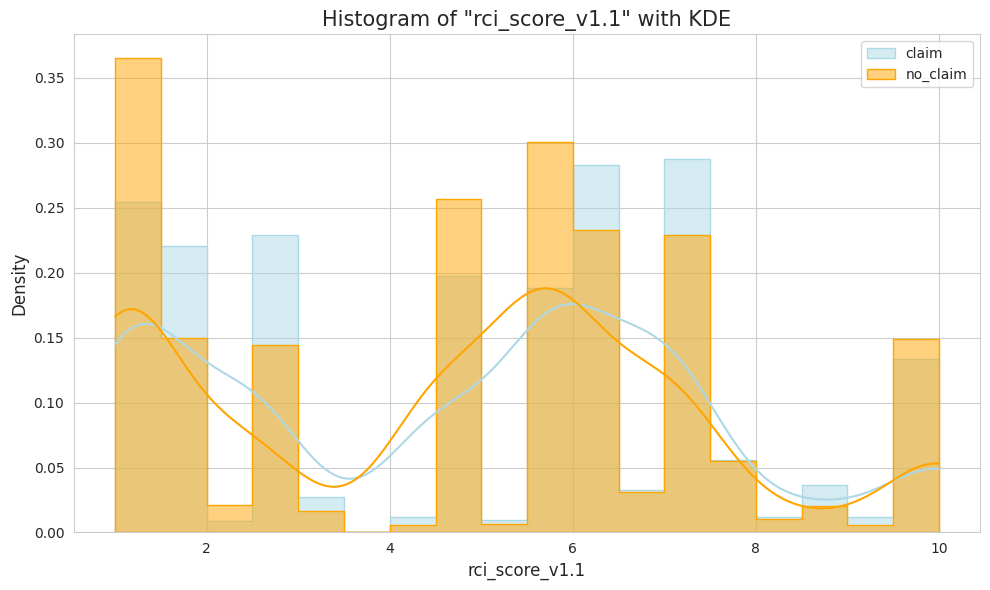

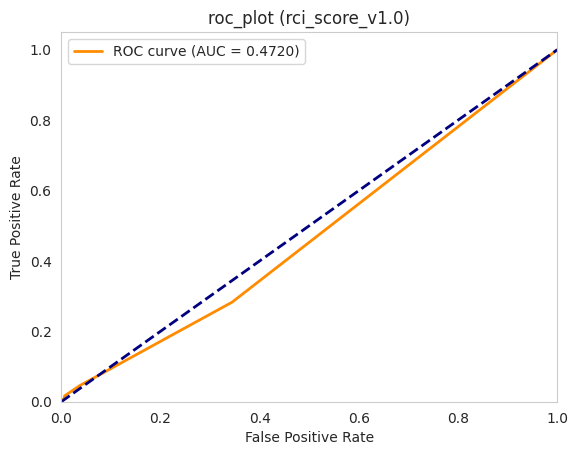

Gini stat: -0.0561


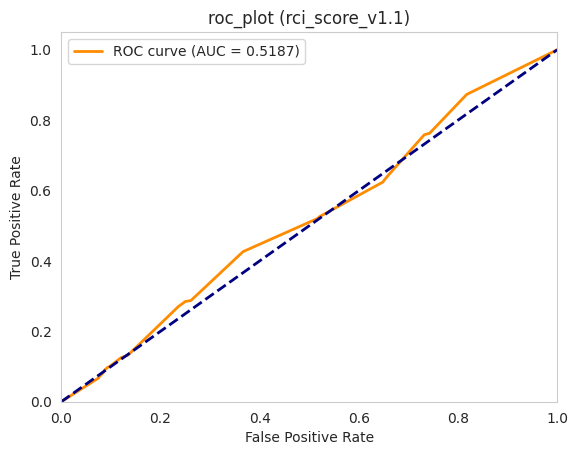

Gini stat: 0.0373


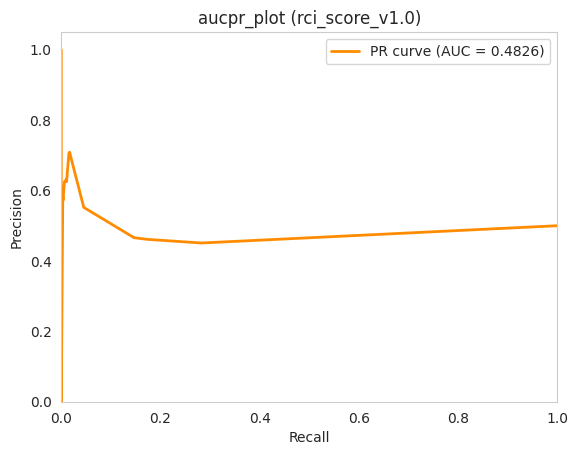

PR AUC: 0.4826


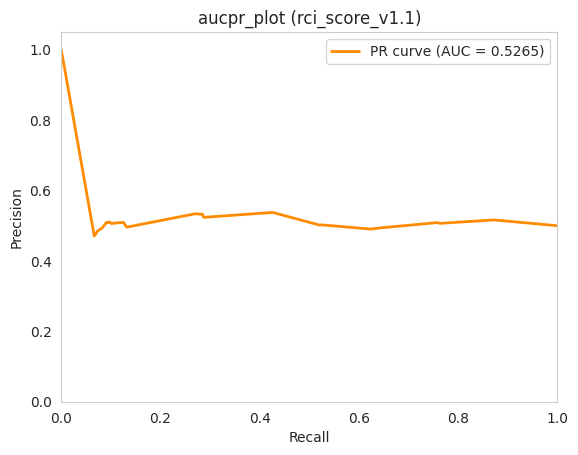

PR AUC: 0.5265

---
Zip Sampled (1:1) Processing ...
Column 'run_completed' converted from bool to int.
Column 'claim_exists' converted from bool to int.


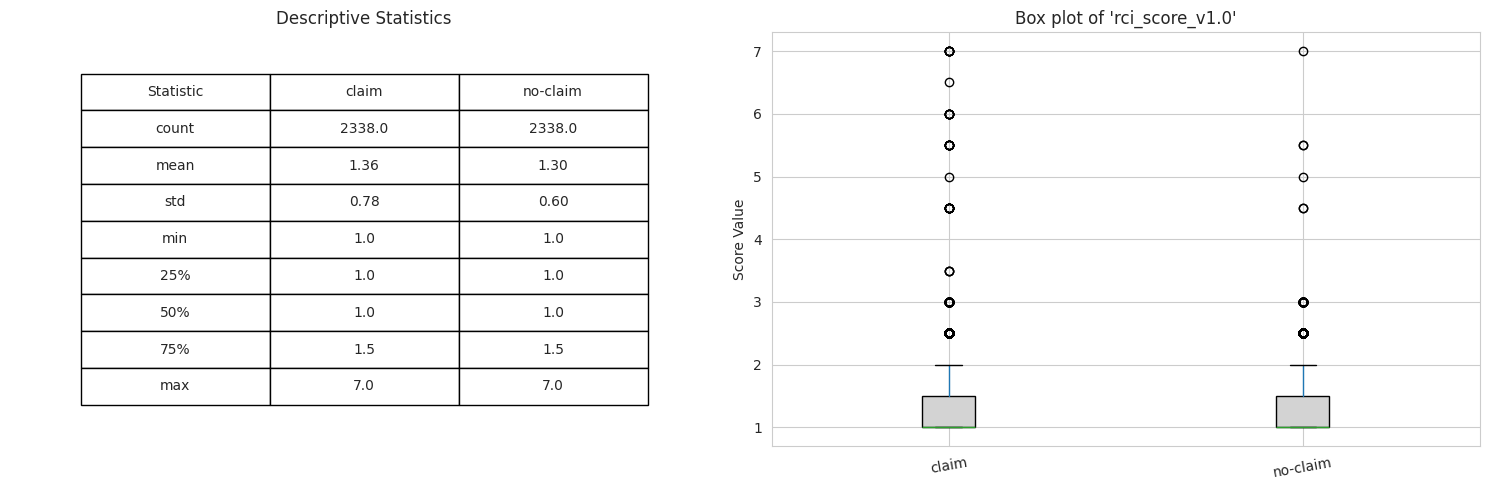

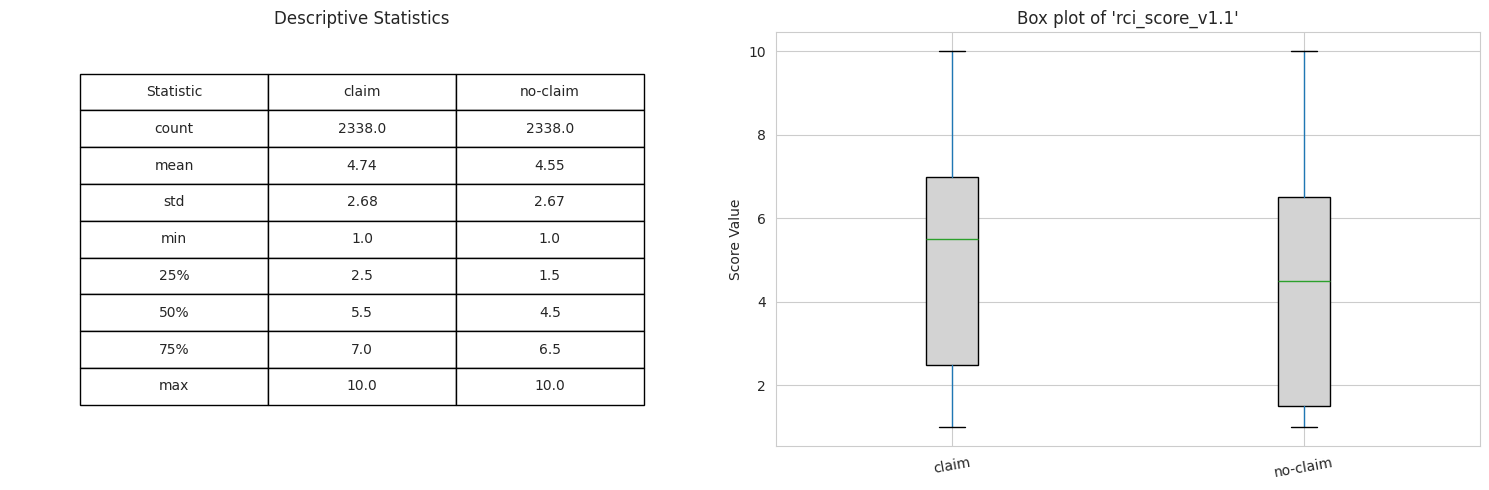

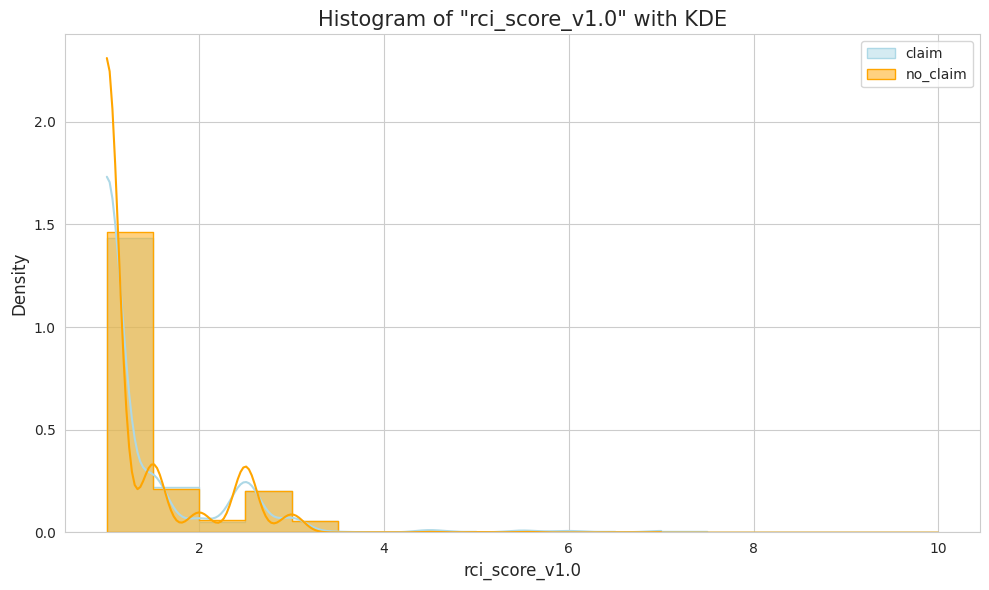

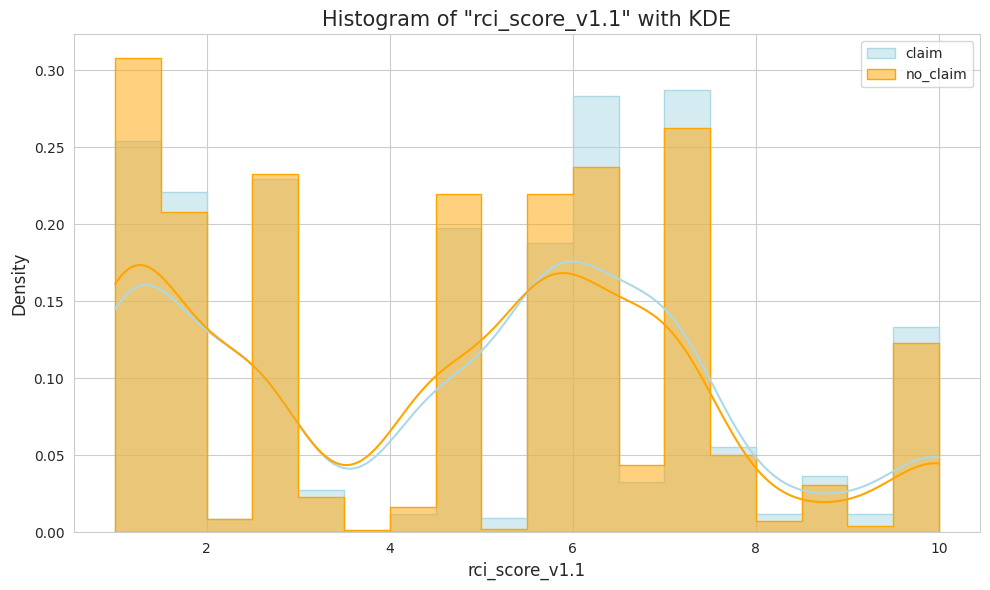

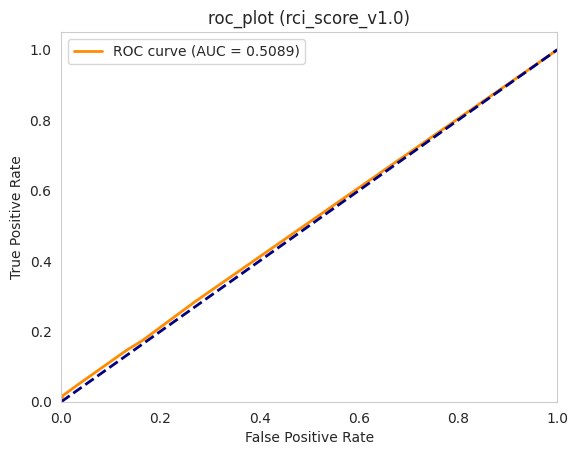

Gini stat: 0.0179


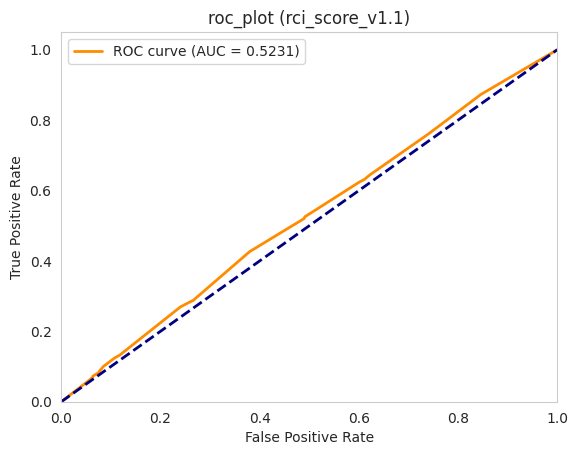

Gini stat: 0.0463


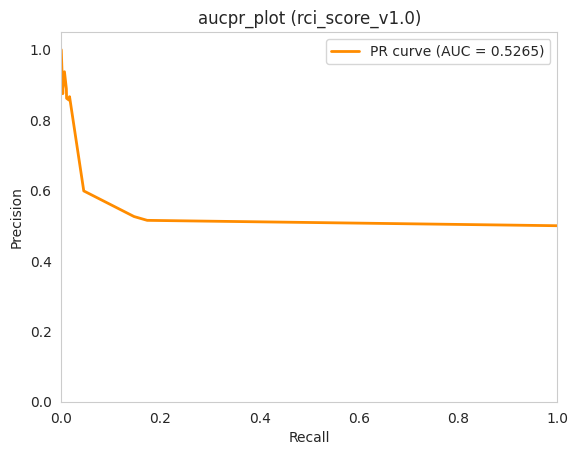

PR AUC: 0.5265


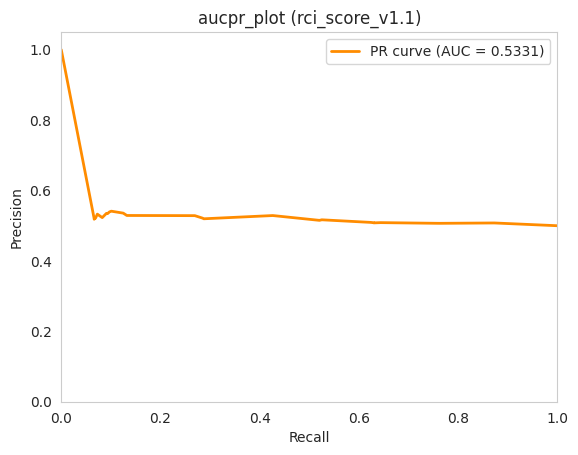

PR AUC: 0.5331

---
State Sampled (1:1) Processing ...
Column 'run_completed' converted from bool to int.
Column 'claim_exists' converted from bool to int.


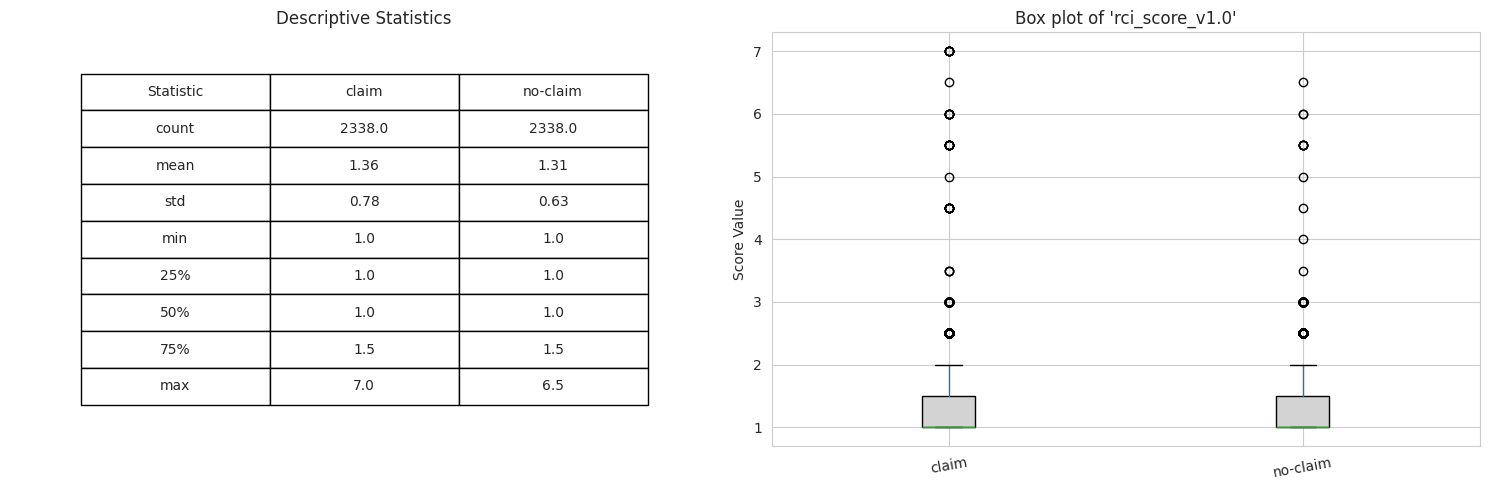

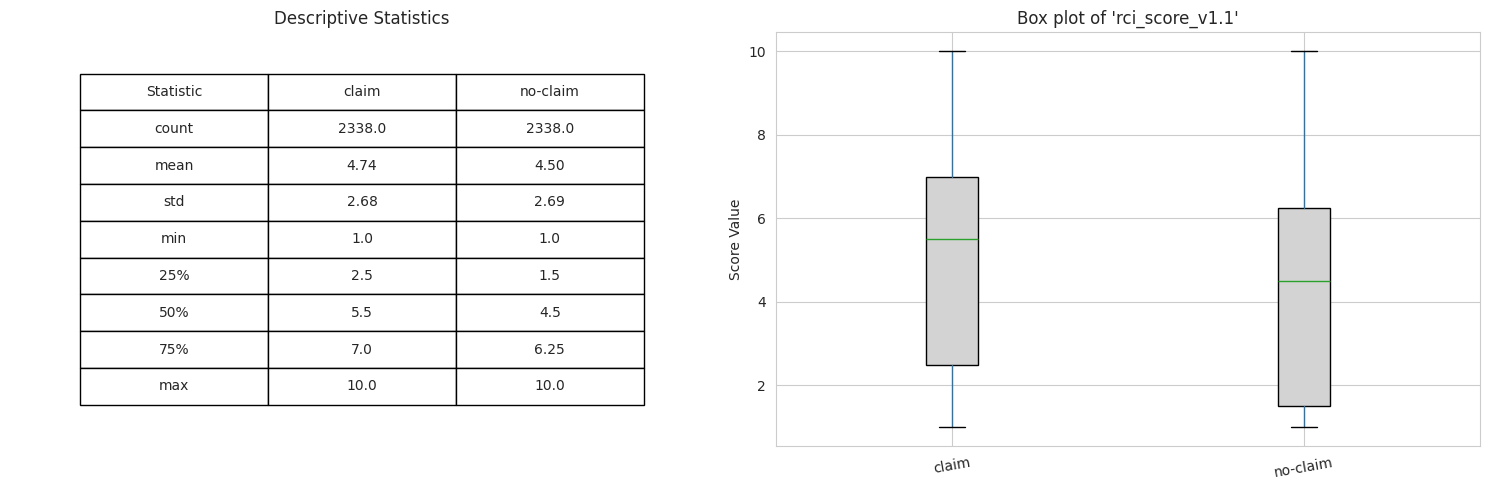

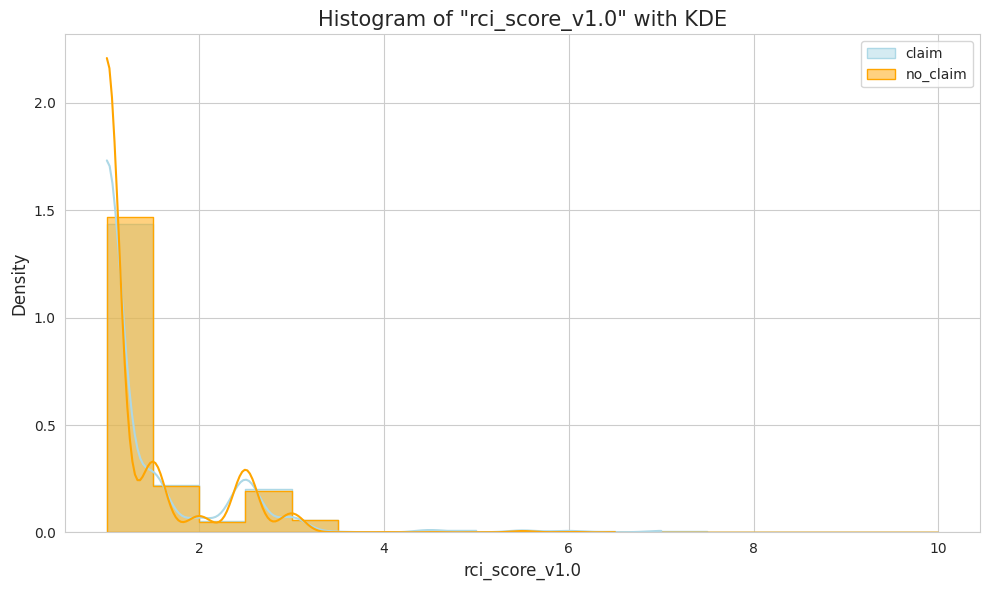

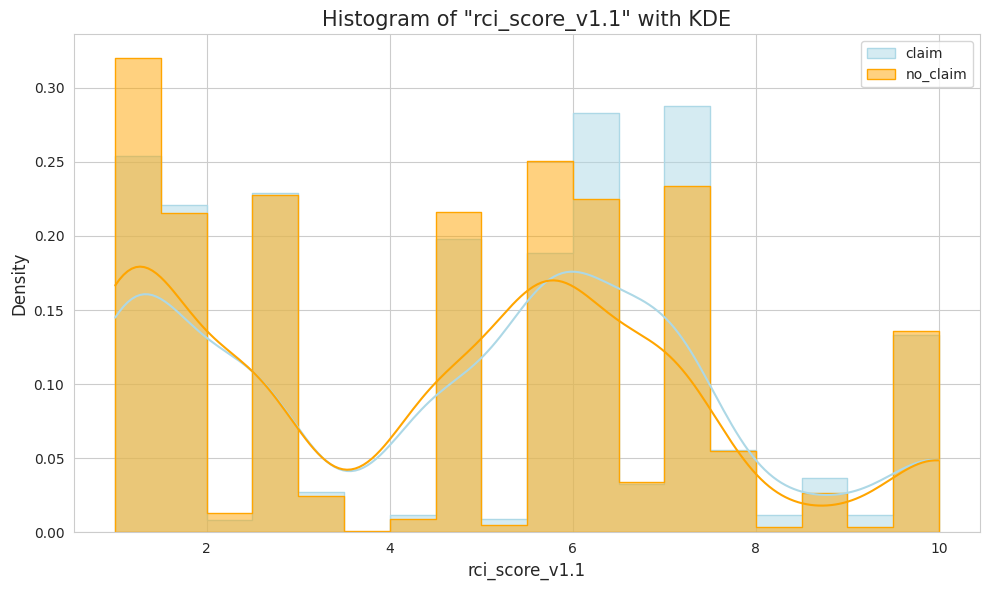

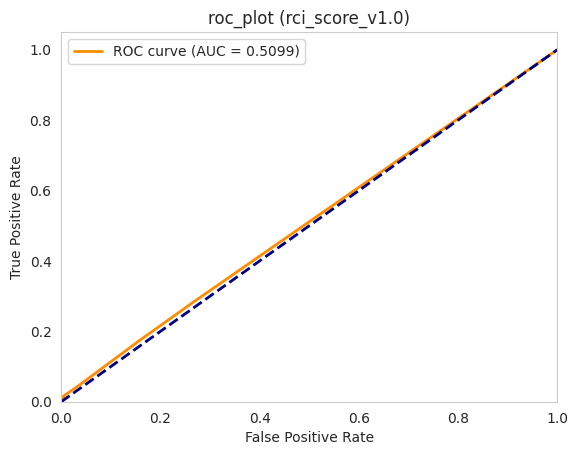

Gini stat: 0.0198


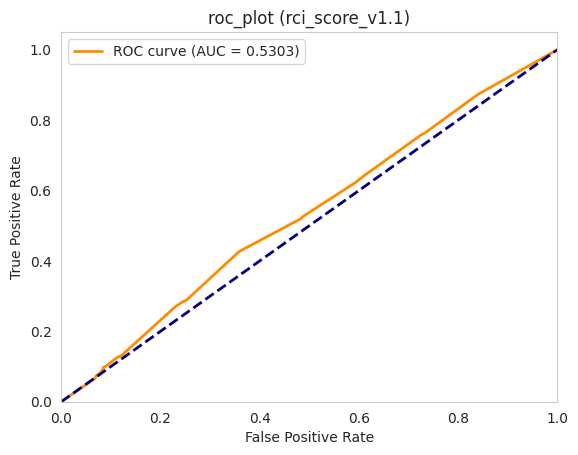

Gini stat: 0.0607


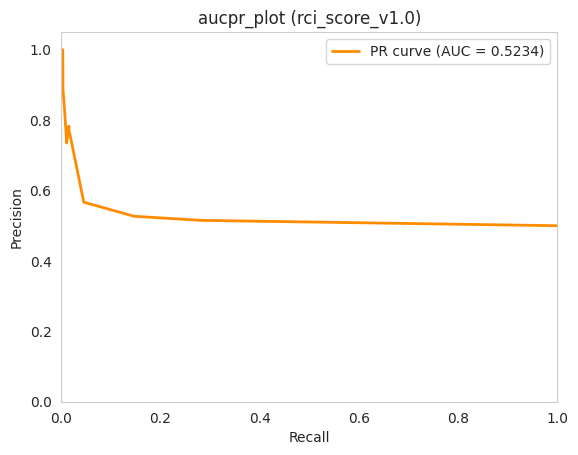

PR AUC: 0.5234


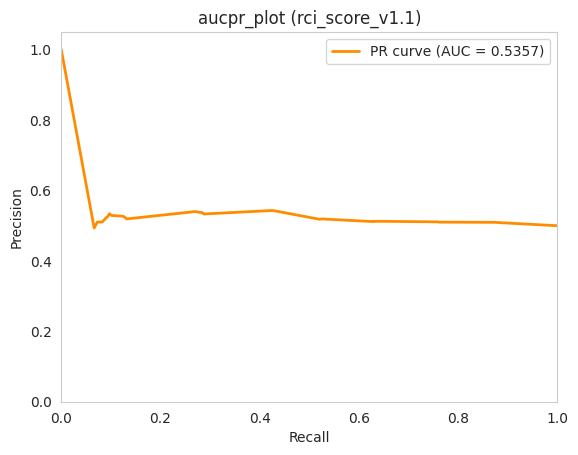

PR AUC: 0.5357

---
National Sampled (1:5) Processing ...
Column 'run_completed' converted from bool to int.
Column 'claim_exists' converted from bool to int.


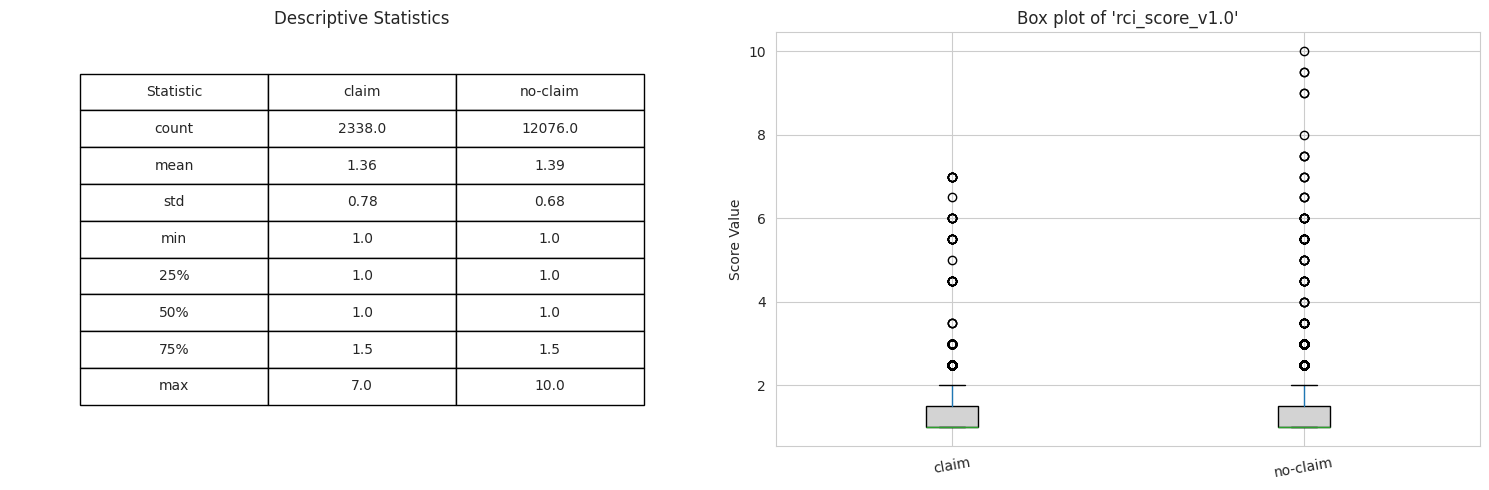

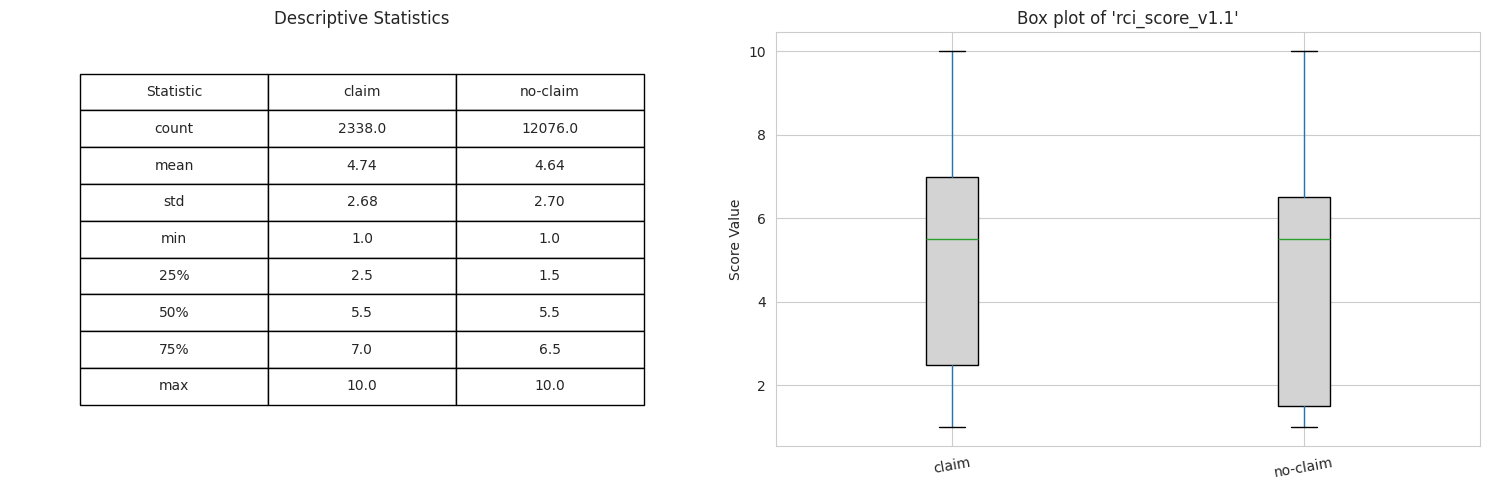

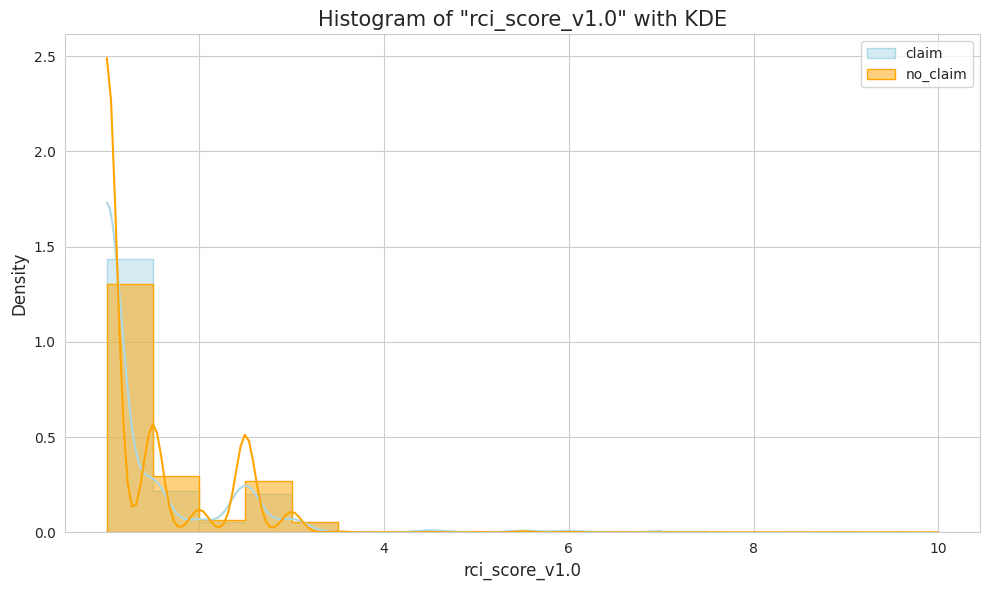

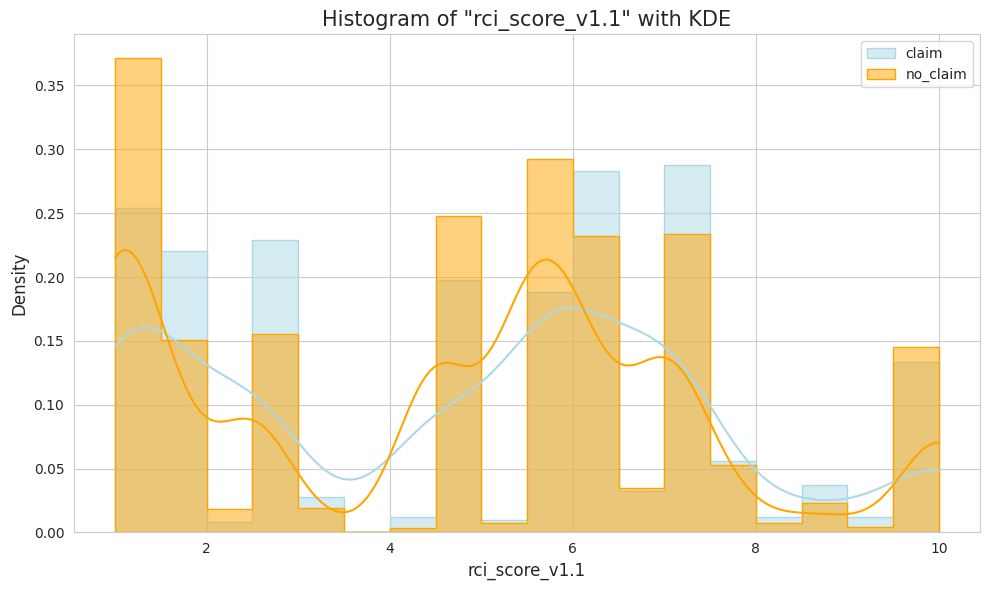

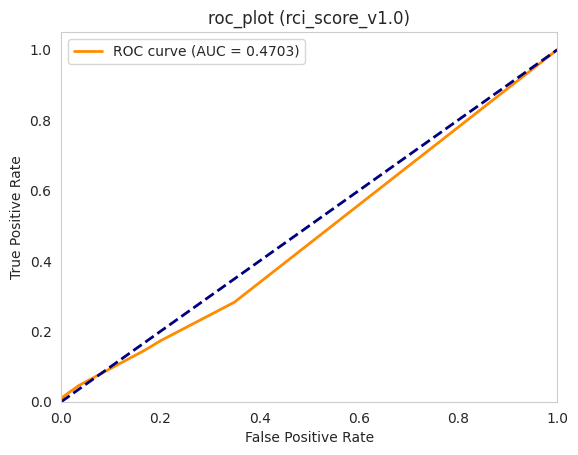

Gini stat: -0.0594


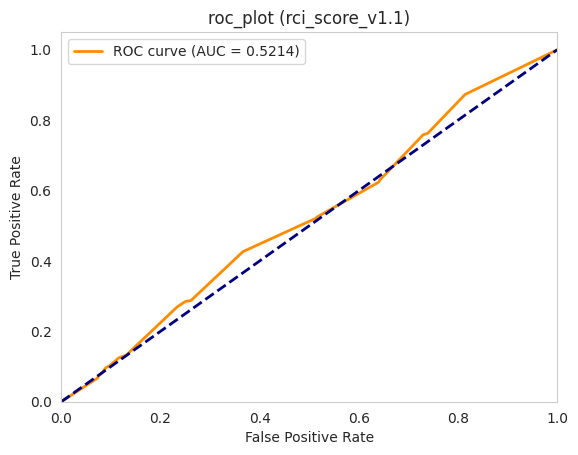

Gini stat: 0.0428


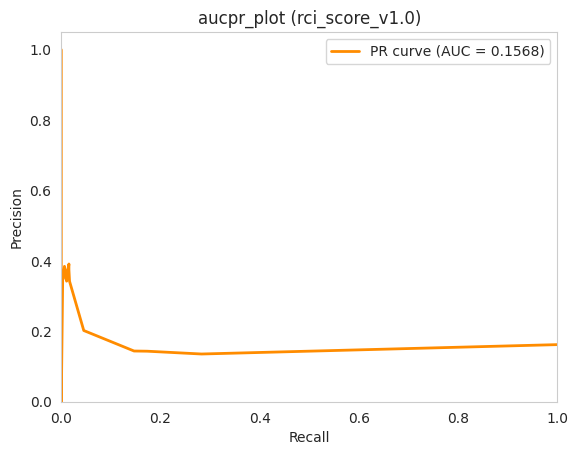

PR AUC: 0.1568


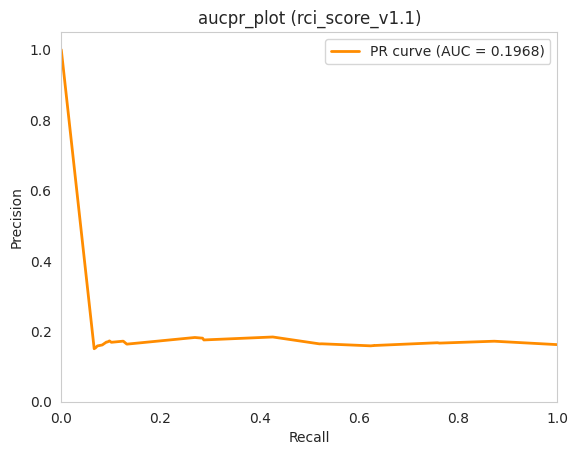

PR AUC: 0.1968


In [76]:
# change the list columns to string
def contains_non_hashable(column):
    for item in column:
        if isinstance(item, (list, dict, set)):
            return True
    return False

for ind, df in enumerate(sampled_dfs):
    # change the bool columns to int
    print(f'\n---\n{indeces[ind]} Processing ...')
    balanced_merged_df = df.copy()
    
    for col in balanced_merged_df.columns:
        if contains_non_hashable(balanced_merged_df[col]):
            print(f"Column '{col}' contains non-hashable types.")
            balanced_merged_df[col] = balanced_merged_df[col].apply(lambda x: str(x) if isinstance(x, list) else x)

    for col in balanced_merged_df.columns:
        # Check if the column is of boolean type
        if balanced_merged_df[col].dtype == 'bool':
            # Convert the boolean column to integer
            balanced_merged_df[col] = balanced_merged_df[col].astype(int)
            print(f"Column '{col}' converted from bool to int.")

    # stats_df = dr.create_stats_df(balanced_merged_df)
    # stats_df

    df_claim = balanced_merged_df[balanced_merged_df['claim_exists'] == True]
    df_no_claim = balanced_merged_df[balanced_merged_df['claim_exists'] == False]

    dr.compare_score_distributions([df_claim, df_no_claim], 
                                score_column='rci_score_v1.0', labels=['claim', 'no-claim'], colors=None)
    dr.compare_score_distributions([df_claim, df_no_claim], 
                                score_column='rci_score_v1.1', labels=['claim', 'no-claim'], colors=None)

    dr.plot_histograms(dataframes=[df_claim, df_no_claim], 
                       column_name='rci_score_v1.0', 
                       labels=['claim', 'no_claim'], xrange=(1,10), bins=18)

    dr.plot_histograms(dataframes=[df_claim, df_no_claim], 
                       column_name='rci_score_v1.1', 
                       labels=['claim', 'no_claim'], xrange=(1,10), bins=18)
    pp.plot_roc_curve(balanced_merged_df,
                      score='rci_score_v1.0', 
                      plot_name='roc_plot (rci_score_v1.0)', 
                      label='claim_exists', 
                      save=False)
    pp.plot_roc_curve(balanced_merged_df,
                      score='rci_score_v1.1', 
                      plot_name='roc_plot (rci_score_v1.1)', 
                      label='claim_exists', 
                      save=False)
    pp.plot_precision_recall_curve(balanced_merged_df,
                      score='rci_score_v1.0', 
                      plot_name='aucpr_plot (rci_score_v1.0)', 
                      label='claim_exists', 
                      save=False)
    pp.plot_precision_recall_curve(balanced_merged_df,
                      score='rci_score_v1.1', 
                      plot_name='aucpr_plot (rci_score_v1.1)', 
                      label='claim_exists', 
                      save=False)
    pp.calculate_gains_and_fprs(balanced_merged_df,
                      score_col='rci_score_v1.0', 
                      target='claim_exists', 
                    segment_list=[1, 5, 10, 15, 20])
    pp.calculate_gains_and_fprs(balanced_merged_df,
                      score_col='rci_score_v1.1', 
                      target='claim_exists', 
                    segment_list=[1, 5, 10, 15, 20])

In [41]:
pp.calculate_gains_and_fprs(balanced_merged_df,
                  score_col='score_v1.1', 
                  target='claim_2023', 
                segment_list=[1, 5, 10, 15, 20])

,Top Population %,Target Captured %,FP / TP
0,1,0.9,1.19 (0.99)
1,5,4.8,1.07 (0.99)
2,10,10.3,0.92 (0.99)
3,15,15.3,0.95 (0.99)
4,20,19.8,1.01 (0.99)
